In [25]:
import os
import re
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import onnxruntime as ort
from sqlalchemy import create_engine
from nostril import nonsense_detector as nd
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
from transformers import BertTokenizer

In [26]:
# data
def get_data():
  engine_name = f"postgresql://{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}@{os.getenv('DB_HOST')}:{os.getenv('DB_PORT')}/{os.getenv('DB_NAME')}"
  engine = create_engine(engine_name)

  query_sql = "SELECT * FROM fb_data"
  df = pd.read_sql_query(query_sql, con=engine)
  return df

def process_text(text):
  TAG_RE = re.compile(r'<[^>]+>')
  URL_RE = re.compile(r'http[s]?://\S+')
  text = URL_RE.sub('', text)
  text = TAG_RE.sub('',text)
  text = re.sub('[^a-zA-Z]', ' ', text)
  text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
  text = re.sub(r'\s+', ' ', text).strip()
  return text

def map_label_to_class(label):
  SOURCES = {
    0: ["nytimes","cnn","nbc"],
    1: ["FoxNews","DailyMail","NYPost"],
    2: ["bbcnews","Reuters","APNews"]
  }

  for class_label, sources in SOURCES.items():
      if label in sources:
          return class_label
  raise ValueError(f"Label '{label}' not found in any source categories.")


def process_data(df):
  df['text'] = df['text'].apply(process_text)
  df['source'] = df['source'].apply(map_label_to_class)
  df.drop(columns=['id'])

  return df

def extract_new_tokens(texts, tokenizer):
    all_tokens = set()
    new_tokens = set()
    
    for text in texts:
        tokens = re.findall(r'\b\w+\b', text)  
        all_tokens.update(tokens)
    
    for token in all_tokens:
        if token.lower() not in tokenizer.vocab:  
            new_tokens.add(token)
    
    return list(new_tokens)

def display_data(df):
  label_counts = df['source'].value_counts().sort_index()
  plt.bar(label_counts.index, label_counts.values, color=['blue', 'red', 'green'])
  plt.xticks(label_counts.index, ['left', 'right', 'center'])  
  plt.xlabel('Label')
  plt.ylabel('Count')
  plt.title('Count of Labels')
  plt.show()

In [27]:
# dataset initialization
class FBData(Dataset):
  def __init__(self,df,device):
    df.drop(columns=['id'])
    self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    new_tokens = extract_new_tokens(df['text'],self.tokenizer)
    self.tokenizer.add_tokens(new_tokens)
    self.data = df
    self.device = device
  
  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    text = self.data['text'][idx]
    label = self.data['source'][idx]
    vectorized_text = self.tokenizer(
      text,
      return_tensors='pt',
      truncation=True,
      )
    input = vectorized_text['input_ids'].squeeze(0)
    return input.to(self.device),torch.tensor(label).to(self.device)

In [28]:
# model
class BiasClassificationModel(nn.Module):
  def __init__(self,input_size,embed_dim,hidden_dim_1,num_class):
    super(BiasClassificationModel,self).__init__()
    self.embed = nn.EmbeddingBag(input_size,embed_dim)
    self.fc1 = nn.Linear(embed_dim, hidden_dim_1)
    self.fc2 = nn.Linear(hidden_dim_1, num_class)
    self.relu = nn.LeakyReLU()
  
  def forward(self,text):
    embed = self.embed(text)
    output = self.relu(self.fc1(embed))
    output = self.fc2(output)
    return F.softmax(output,dim=1)

In [29]:
# split data 

def collate_fn(batch):
    inputs, labels = zip(*batch)
    inputs = pad_sequence(inputs, batch_first=True, padding_value=0)
    labels = torch.stack(labels)
    return inputs, labels

def split_data(dataset,batch_size):
  train_idx, test_idx = train_test_split(range(len(dataset)),test_size=0.2,random_state=42,shuffle=True)
  train_dataset = Subset(dataset,train_idx)
  test_dataset = Subset(dataset,test_idx)
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
  return train_loader, test_loader

In [30]:
# train and test
def train(dataloader,model,optimizer,criterion,verbose):
  model.train()
  train_loss = 0
  train_acc = 0
  total_samples = 0

  for text,label in tqdm(dataloader, disable=not verbose):
    optimizer.zero_grad()
    
    output = model(text)
    loss = criterion(output,label)

    train_loss += loss.item()
    train_acc += (output.argmax(1) == label).sum().item()
    total_samples += text.size(0)

    loss.backward()
    optimizer.step()

  train_loss/=total_samples
  train_acc/=total_samples

  return train_loss, train_acc, model, optimizer, criterion

def test(dataloader,model,criterion, verbose):
  model.eval()
  test_loss = 0
  test_acc = 0
  total_samples = 0
  test_preds = []
  test_labels = []

  with torch.no_grad():
    for text,label in tqdm(dataloader,disable=not verbose):
      output = model(text)
      loss = criterion(output,label)
      test_loss += loss.item()
      test_acc += (output.argmax(1) == label).sum().item()
      total_samples += text.size(0)

      test_preds.extend(output.argmax(1).cpu().numpy())
      test_labels.extend(label.cpu().numpy())
      
  test_loss/=total_samples
  test_acc/=total_samples
  return test_loss,test_acc, test_preds, test_labels

def train_test_loop(path,device,train_loader,test_loader,num_epochs,model,optimizer,criterion,verbose):
  print('Training Classification NN Starting')

  train_losses = []
  train_accs = []
  test_losses = []
  test_accs = []
  for epoch in range(num_epochs):
    train_loss, train_acc, model, optimizer, criterion = train(train_loader,model,optimizer,criterion,verbose)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    if verbose: print(f'Training Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}')

    test_loss, test_acc, test_preds, test_labels  = test(test_loader,model,criterion,verbose)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    if verbose: print(f'Test Epoch [{epoch + 1}/{num_epochs}], Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}')
  
  
  model.eval()
  input, _ = next(iter(test_loader))
  dummy_input = torch.randn(1,input.shape[1]).int().to(device)
  torch.onnx.export(
    model,
    dummy_input,
    path,
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes = {
      'input' : {0: 'batch_size', 1: 'sequence_length'},
      'output' : {0: 'batch_size'}
    }
  )
  

  print('Model Saved - Training Done, Final Testing Results Are As Shown:')
  print(f'Training Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}')
  print(f'Test Epoch [{epoch + 1}/{num_epochs}], Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}')

  plt.plot(train_losses,label='Train Loss')
  plt.plot(test_losses,label='Test Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  plt.plot(train_accs,label='Train Acc')
  plt.plot(test_accs,label='Test Acc')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy %')
  plt.legend()
  plt.show()

  cm = confusion_matrix(test_labels, test_preds)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
  disp.plot(cmap='Blues')
  plt.title('Confusion Matrix: Predicted vs Actual Labels')
  plt.show()

  return model

In [31]:
# predict
def predict_text(text,session,dataset):
  text = process_text(text)
  vectorized_text = dataset.tokenizer(
      text,
      return_tensors='np',
      truncation=True,
      )
  print(vectorized_text['input_ids'])
  onnx_input = {
    'input' : vectorized_text['input_ids']
  }
  output = session.run(None,onnx_input)[0][0]
  prediction = output.argmax()

  label_map = {0: 'left', 1: 'right', 2: 'center'}
  prediction = label_map.get(prediction, 'Prediction error.')
  probabilities_percentage = [f"{p * 100:.1f}%" for p in output]

  print(f'The text provided leans towards {prediction} with a probability of '
          f'{probabilities_percentage[0]} for left, {probabilities_percentage[1]} for right, and '
          f'{probabilities_percentage[2]} for center.')

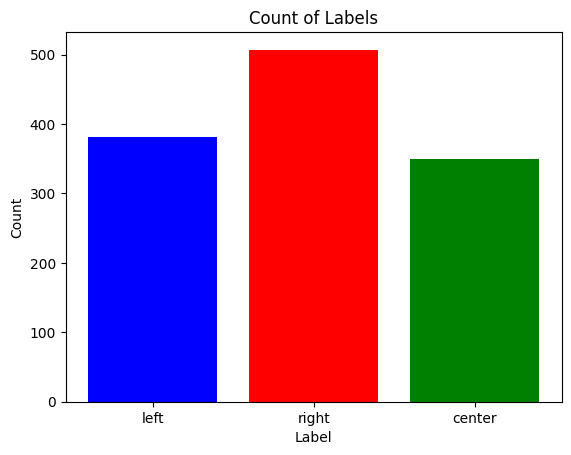

c:\.Work\projects\Media-Bias-Detector\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


cuda
Training Classification NN Starting


100%|██████████| 990/990 [00:04<00:00, 210.70it/s]


Training Epoch [1/5], Loss: 1.0267, Accuracy: 0.4909


100%|██████████| 248/248 [00:00<00:00, 312.29it/s]


Test Epoch [1/5], Loss: 0.9704, Accuracy: 0.5242


100%|██████████| 990/990 [00:04<00:00, 221.97it/s]


Training Epoch [2/5], Loss: 0.8900, Accuracy: 0.6525


100%|██████████| 248/248 [00:00<00:00, 312.70it/s]


Test Epoch [2/5], Loss: 0.9169, Accuracy: 0.6290


100%|██████████| 990/990 [00:04<00:00, 224.47it/s]


Training Epoch [3/5], Loss: 0.7704, Accuracy: 0.8253


100%|██████████| 248/248 [00:00<00:00, 316.58it/s]


Test Epoch [3/5], Loss: 0.8479, Accuracy: 0.7016


100%|██████████| 990/990 [00:04<00:00, 221.44it/s]


Training Epoch [4/5], Loss: 0.6757, Accuracy: 0.9061


100%|██████████| 248/248 [00:00<00:00, 315.16it/s]


Test Epoch [4/5], Loss: 0.8441, Accuracy: 0.7056


100%|██████████| 990/990 [00:04<00:00, 219.83it/s]


Training Epoch [5/5], Loss: 0.6214, Accuracy: 0.9465


100%|██████████| 248/248 [00:00<00:00, 319.80it/s]


Test Epoch [5/5], Loss: 0.8362, Accuracy: 0.7016
Model Saved - Training Done, Final Testing Results Are As Shown:
Training Epoch [5/5], Loss: 0.6214, Accuracy: 0.9465
Test Epoch [5/5], Loss: 0.8362, Accuracy: 0.7016


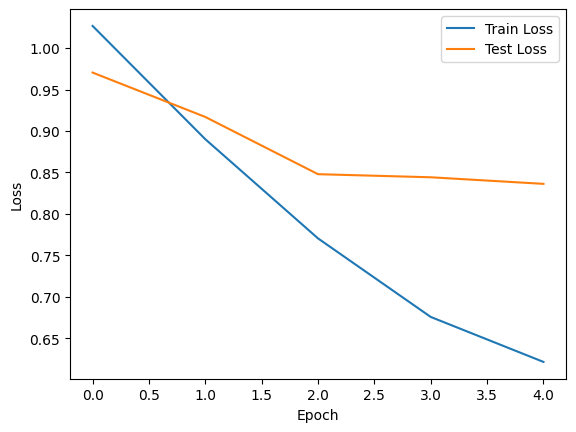

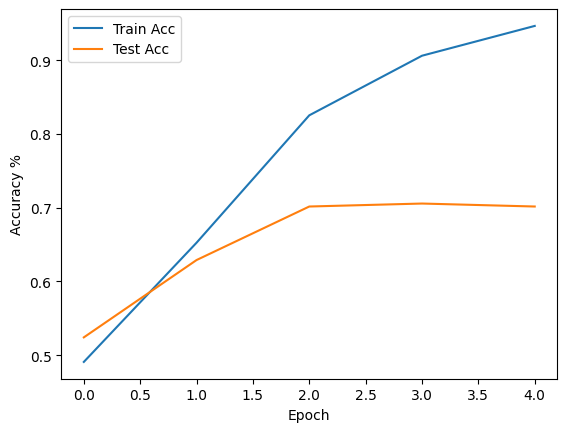

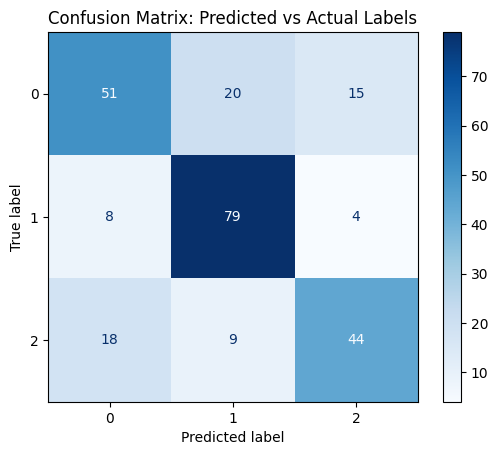

[[  101  4911  2739  3648 30984  3968  2167  7734  2379  2561 11324  7221
   3038  2049  4552 30637 14925  3215  1996  2157  2000  2019 11324  2127
  10768  5809  2003 14874   102]]
The text provided leans towards left with a probability of 54.6% for left, 0.1% for right, and 45.3% for center.


In [32]:
def main(text,batch_size,num_epochs,verbose,override):
  device = ('cuda' if torch.cuda.is_available() else 'cpu')

  if nd.nonsense(text):
    raise Exception("Gibberish Text Detected") 
  
  nn_path = 'classification_model.onnx'

  df = get_data()
  df = process_data(df)
  
  if (override or not os.path.exists(nn_path) and verbose):
    display_data(df)
    print(device)
  
  dataset = FBData(df,device)
  train_loader, test_loader = split_data(dataset,batch_size)

  input_size = len(dataset.tokenizer)
  embed_dim = 64
  hidden_dim_1 = 32
  num_classes = 3
  model = BiasClassificationModel(input_size,embed_dim,hidden_dim_1,num_classes).to(device)

  if(override or not os.path.exists(nn_path)):
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3,weight_decay=1e-5)
    criterion = torch.nn.CrossEntropyLoss()
    train_test_loop(nn_path,device,train_loader,test_loader,num_epochs,model,optimizer,criterion,verbose)
  
  session = ort.InferenceSession(nn_path)

  if(text is not None):
    predict_text(text,session,dataset)

text = "Breaking News: A judge overturned North Dakota’s near-total abortion ban, saying its Constitution protects the right to an abortion until a fetus is viable."
main(text,batch_size=1,num_epochs=5,verbose=True,override=True)